# Artificial Intelligence Course - Fall 1402
## Computer Assignment #5 - Convolutional Neural Networks (CNN) 

### Mehdi Jamalkhah, SID: 810100111 

### Table of Contents<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Data Set](#toc2_)    
- [Preprocessing Data](#toc3_)    
  - [Over Sampling](#toc3_1_)    
  - [Normalization](#toc3_2_)    
  - [Train Test Split](#toc3_3_)    
- [CNN Architecture](#toc4_)    
- [Optimaizer](#toc5_)    
- [Loss Function](#toc6_)    
- [Regularization](#toc7_)    
- [Results](#toc8_)    
- [References](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

<a name='0'></a>
## <a id='toc1_'></a>Introduction [](#toc0_)
In this computer assignment, we will be applying CNN to classify images. To accomplish this, we will be using the `PyTorch` framework. Our main focus will be on determining various hyperparameters and different functions within each layer of the network.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Import
import os
import numba.cuda as cuda
import random
import gc
import torch
import numpy as np
from math import floor
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.optim import Adam
from torchsummary import summary
from torch import flatten
import torch.nn as nn
from torch.nn import ReLU
from torch.nn import Module
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import Dropout
from torch.nn import MaxPool2d
from torch.nn import LogSoftmax
from torch.nn import BatchNorm2d
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

<a name='1'></a>
## <a id='toc2_'></a>Data Set [](#toc0_)
Our dataset consists of MRI images categorized into four distinct types, with varying quantities of images for each type.

<a name='2'></a>
## <a id='toc3_'></a>Preprocessing Data [](#toc0_)
First, we will implement a personalized dataset class that inherits from the `Dataset` class in `PyTorch`.

As the images can have diffrent sizes, they will be resized to a same size.

In [2]:
# Hyper parameter
size = (512, 512)

In [3]:
q = [1, 2, 3]
q = q[:2] + [4, 5] +  q[2:]
print(q)

[1, 2, 4, 5, 3]


In [4]:
class ImageDataset(Dataset):
    def __init__(self, root_dir) -> None:
        super().__init__()

        self.samples = list()
        self.size = list()
        self.classes = list()

        for subfolder in os.listdir(root_dir):
            subfolder_path = os.path.join(root_dir, subfolder)
            if os.path.isdir(subfolder_path):
                count = 0
                for filename in os.listdir(subfolder_path):
                    image_path = os.path.join(subfolder_path, filename)

                    resize = transforms.Resize((size))
                    to_tensor = transforms.ToTensor()

                    image = resize(Image.open(image_path))
                    self.samples.append((to_tensor(image), len(self.size)))
                    count += 1

                self.size.append(count)
                self.classes.append(subfolder)

    def over_sample(self):
        max_size = max(self.size)
        last = 0
        for size in self.size:
            end = last + size
            new_samples = random.choices(self.samples[last:end], k=max_size - size)
            self.samples = self.samples[:end] + new_samples + self.samples[end:]
            last += max_size

        self.size = [max_size for i in range(len(self.size))]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        return self.samples[index]

    def convert_to_rgb(self):
        for i in range(len(self.samples)):
            image, label = self.samples[i]
            if(image.shape[0] == 1):
                rgb_image = torch.cat((image, image, image), dim=0)
                self.samples[i] = (rgb_image, label)

    def normalize(self):

        mean = [0, 0, 0]
        std = [1, 1, 1]

        normalize = transforms.Normalize(mean=mean, std=std)
        for i in range(len(self.samples)):
            image, label = self.samples[i]
            self.samples[i] = (normalize(image), label)

    def show_sample(self):
        fig, axs = plt.subplots(nrows=1, ncols=len(self.size), figsize=(20, 20))
        index = 0
        for i in range(len(self.size)):
            image, label = self.samples[index]
            axs[i].imshow(image.numpy().T)
            axs[i].axis('off')
            axs[i].set_title(self.classes[label])
            index += self.size[i]
        plt.show()

    def targets(self):
        return np.array([test_data[i][1] for i in range(len(test_data))])

In [5]:
root_dir = "/content/drive/MyDrive/data"
dataset = ImageDataset(root_dir)

Some images are grayscale while others are not. Therefore, we convert the grayscale images to RGB format by replicating their single channel.**Note** that we do not perform the reverse conversion to avoid losing any features.

In [6]:
dataset.convert_to_rgb()

<a name='2-0'></a>
### <a id='toc3_1_'></a>Over Sampling [](#toc0_)
We over  sample the classes to have same number of samples.

In [58]:
dataset.over_sample()
dataset.size

[405, 405, 405, 405]

<a name='2-1'></a>
### <a id='toc3_2_'></a>Normalization [](#toc0_)

Advantage
* **Elimination of Bias**: Normalization can remove any bias or offset in pixel intensity that may be present in the image due to variations in lighting conditions or sensor characteristics. By shifting the pixel values to a common baseline, normalization can help mitigate these biases.

**Disadvantage**
1. **Loss of Information**: In certain cases, normalization can lead to the loss of information, particularly when the dynamic range of the image is already well-utilized. Extreme normalization techniques may compress the pixel values, causing a loss of subtle details or fine texture in the image.

2. **Over- or Under-Normalization**: Improper normalization techniques or parameter settings can lead to over-normalization or under-normalization. Over-normalization can result in loss of important details or make the image appear unnatural, while under-normalization may fail to address the desired objectives of normalization.

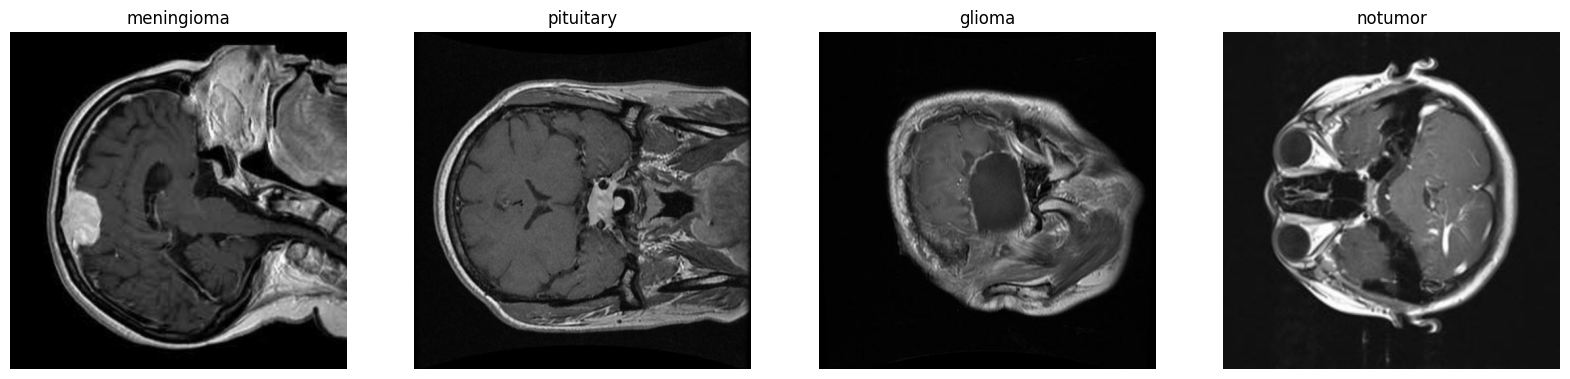

In [9]:
dataset.normalize()
dataset.show_sample()

<a name='2-2'></a>
### <a id='toc3_3_'></a>Train Test Split [](#toc0_)
We consider 25 percent of data as test

In [10]:
# Hyper parameter
TRAIN_SIZE = 0.75

In [11]:
num_train_samples = floor(len(dataset) * TRAIN_SIZE)
num_test_samples = len(dataset) - num_train_samples

train_data, test_data = random_split(dataset, [num_train_samples, num_test_samples], generator=torch.Generator().manual_seed(42))

<a name='3'></a>
## <a id='toc4_'></a>CNN Architecture [](#toc0_)
Let's discuss how we determined the hyperparameters for our CNN.
* **Filter size**

    Smaller filters collect as much local information as possible, bigger filters represent more global, high-level and representive information. Because a big amount of pixels are necessary for the network to recognize the tumor we will use** large filters** (as 11x11 and 9x9). **Note in general we use filters with odd sizes**


* **Padding**

    We use a **large padding** because border's of the image is important and usually tumor is near to the edge of image.

* **stride**

    We chose a **relatively larger stride** for our CNN because the images contain minimal details, including a significant amount of black pixels. Therefore, there is no need to complicate the model by shifting the kernel pixel by pixel.
* **FC**

    We don't want to make our first FC layer too big, because it contains most of model parameters, or, in other words, consumes most memory. E.g. VGGNet has 7*7*512*4096 = 102,760,448 parameters in FC layer, which is 72% of all network parameters. Making it twice as big will make it 85%!<br>
    Conv layers are much more important in terms of accuracy, than the way they are combined in the top layers. There's nothing wrong with three or more FC layers


> **Principle/Convention to build a CNN architecture**
<br>
    Keep the feature space wide and shallow in the initial stages of the network,  and the make it narrower and deeper towards the end.

Keeping the above principle in mind we lay down a few conventions to building our CNN architecture.

1. Start by using smaller filters to collect as much local information as possible, and then gradually increase the filter width to reduce the generated feature space width to represent more global, high-level and representative information.

2. Following the principle, the number of channels should be low in the beginning such that it detects low-level features which are combined to form many complex shapes(by increasing the number of channels) which help distinguish between classes.

3. The number of filters is increased to increase the depth of the feature space thus helping in learning more levels of global abstract structures. One more utility of making the feature space deeper and narrower is to shrink the feature space for input to the dense networks.

We keep adding layers until over-fit. As once we achieved a considerable accuracy in train set we use regularization components like dropout and batch norm to reduce over-fitting.

In [45]:
class CNN(Module):
    def __init__(self, num_channels, classes, regularization=False):
        super(CNN, self).__init__()
        self.regularization = regularization

        self.batch_norm1 = BatchNorm2d(num_channels)
        self.conv1 = Conv2d(in_channels=num_channels, out_channels=20, kernel_size=(3,3), stride=(3, 3), padding=(2, 2))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.batch_norm2 = BatchNorm2d(20)
        self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(7,7), stride=(3, 3), padding=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.batch_norm3 = BatchNorm2d(50)
        self.conv3 = Conv2d(in_channels=50, out_channels=100, kernel_size=(11,11), stride=(3, 3), padding=(9, 9))
        self.relu3 = ReLU()
        self.maxpool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.dropout1 = Dropout(0.25)
        self.fc1 = Linear(in_features=1600, out_features=500)
        self.relu3 = ReLU()

        self.dropout2 = Dropout(0.5)
        self.fc2 = Linear(in_features=500, out_features=classes)
        self.log_softmax = LogSoftmax(dim=1)


    def forward(self, x):

        if self.regularization:
            x = self.batch_norm1(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        if self.regularization:
            x = self.batch_norm2(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        if self.regularization:
            x = self.batch_norm3(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        if self.regularization:
            x = self.dropout1(x)

        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)

        if self.regularization:
            x = self.dropout2(x)
        x = self.fc2(x)
        output = self.log_softmax(x)

        return output


In [46]:
INIT_LR = 1e-3
BATCH_SIZE = 16
EPOCHS = 40

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
model = CNN(num_channels=3, classes=len(train_data.dataset.size)).to(device)

In [48]:
train_data_loder = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
test_data_loder = DataLoader(test_data, batch_size=BATCH_SIZE)
train_steps = len(train_data_loder.dataset) // BATCH_SIZE
test_steps = len(test_data_loder.dataset) // BATCH_SIZE

<a name='4'></a>
## <a id='toc5_'></a>Optimaizer [](#toc0_)
In this project, we utilize the **Adam** optimizer. Here is a brief explanation of what it is:
It uses the squared gradients to scale the learning rate like **RMSprop**, and it takes advantage of momentum by using the moving average of the gradient instead of the gradient itself, like **SGD** with momentum. This combines Dynamic Learning Rate and Smoothening to reach the global minimal.

> **What is the diffrence between Adam and SGD optimaizer?**
<br>
    Stochastic gradient descent maintains a **single** learning rate (termed alpha) for all weight updates and the learning rate does not change during training.But Adam computes **individual** adaptive learning rates for different parameters from estimates of first and second moments of the gradients.

In [49]:
opt = Adam(model.parameters(), lr=INIT_LR)

<a name='5'></a>
## <a id='toc6_'></a>Loss Function [](#toc0_)
* **Hinge loss**:
    In simple terms, the score of correct category should be greater than sum of scores of all incorrect categories by some safety margin (usually one). And hence hinge loss is used for maximum-margin classification

* **Negative log likelihood loss**:
    It calculates the logarithm of the probability that the predicted class is the same as the true class.The NLL loss is differentiable, making it suitable for optimization algorithms that rely on gradient descent, such as backpropagation. This property allows us to efficiently compute and update the model's parameters to minimize the loss during training.

In [50]:
loss_func = nn.NLLLoss()

In [51]:
print(summary(model, (3, 512, 512)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 172, 172]             560
              ReLU-2         [-1, 20, 172, 172]               0
         MaxPool2d-3           [-1, 20, 86, 86]               0
            Conv2d-4           [-1, 50, 30, 30]          49,050
              ReLU-5           [-1, 50, 30, 30]               0
         MaxPool2d-6           [-1, 50, 15, 15]               0
            Conv2d-7            [-1, 100, 8, 8]         605,100
              ReLU-8            [-1, 100, 8, 8]               0
         MaxPool2d-9            [-1, 100, 4, 4]               0
           Linear-10                  [-1, 500]         800,500
             ReLU-11                  [-1, 500]               0
           Linear-12                    [-1, 4]           2,004
       LogSoftmax-13                    [-1, 4]               0
Total params: 1,457,214
Trainable param

In [52]:
def train(model, train_data_loder, test_data_loder, loss_func, opt, device):
    H = {
	"train_loss": [],
	"train_acc": [],
	"test_loss": [],
	"test_acc": []
    }

    for e in range(EPOCHS):

        torch.cuda.empty_cache()
        gc.collect()

        model.train()

        total_train_loss = torch.tensor(0, dtype=torch.float32, device=device)
        total_test_loss = torch.tensor(0, dtype=torch.float32, device=device)

        train_correct = torch.tensor(0, dtype=torch.float32, device=device)
        test_correct = torch.tensor(0, dtype=torch.float32, device=device)

        for X, y in train_data_loder:

            (X, y) = (X.to(device), y.to(device))

            pred = model(X).to(device)
            loss = loss_func(pred, y).to(device)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_train_loss += loss.item()
            train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        with torch.no_grad():

            model.eval()

            for X, y in test_data_loder:

                X, y = (X.to(device), y.to(device))

                pred = model(X)
                total_test_loss += loss_func(pred, y).item()
                test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        avg_train_loss = total_train_loss / train_steps
        avg_test_loss = total_test_loss / test_steps

        train_correct = train_correct / len(train_data_loder.dataset)
        test_correct = test_correct / len(test_data_loder.dataset)

        H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
        H["train_acc"].append(train_correct.cpu())
        H["test_loss"].append(avg_test_loss.cpu().detach().numpy())
        H["test_acc"].append(test_correct.cpu())


        print("EPOCH: {}/{}".format(e + 1, EPOCHS))
        print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avg_train_loss, train_correct))
        print("Test loss: {:.6f}, Test accuracy: {:.4f}".format(avg_test_loss, test_correct))

    return H

In [53]:
H = train(model, train_data_loder, test_data_loder, loss_func, opt, device)

EPOCH: 1/40
Train loss: 1.155068, Train accuracy: 0.4790
Test loss: 0.912844, Test accuracy: 0.6346
EPOCH: 2/40
Train loss: 0.775065, Train accuracy: 0.6741
Test loss: 0.645133, Test accuracy: 0.7309
EPOCH: 3/40
Train loss: 0.615020, Train accuracy: 0.7514
Test loss: 0.508922, Test accuracy: 0.7852
EPOCH: 4/40
Train loss: 0.479207, Train accuracy: 0.8049
Test loss: 0.518525, Test accuracy: 0.8198
EPOCH: 5/40
Train loss: 0.357683, Train accuracy: 0.8576
Test loss: 0.429253, Test accuracy: 0.8395
EPOCH: 6/40
Train loss: 0.233459, Train accuracy: 0.9160
Test loss: 0.486492, Test accuracy: 0.8568
EPOCH: 7/40
Train loss: 0.143588, Train accuracy: 0.9399
Test loss: 0.466213, Test accuracy: 0.8815
EPOCH: 8/40
Train loss: 0.114434, Train accuracy: 0.9630
Test loss: 0.326916, Test accuracy: 0.9259
EPOCH: 9/40
Train loss: 0.042419, Train accuracy: 0.9901
Test loss: 0.455370, Test accuracy: 0.9160
EPOCH: 10/40
Train loss: 0.035406, Train accuracy: 0.9893
Test loss: 0.432458, Test accuracy: 0.9062

In [41]:
def plot_loss_acc(H):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H["train_loss"], label="train_loss")
    plt.plot(H["train_acc"], label="train_acc")
    plt.plot(H["test_loss"], label="test_loss")
    plt.plot(H["test_acc"], label="test_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

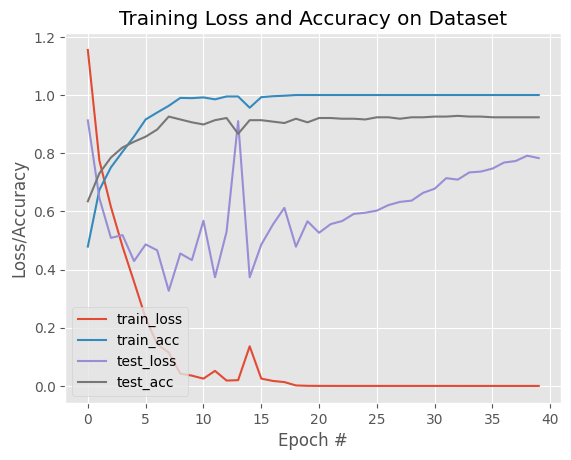

In [54]:
plot_loss_acc(H)

In [38]:
def test(model, test_data, test_data_loder, device):
    with torch.no_grad():

        model.eval()

        preds = []

        for X, y in test_data_loder:

            X = X.to(device)

            pred = model(X)
            preds.extend(pred.argmax(axis=1).cpu().numpy())

    print(classification_report(test_data.dataset.targets(), np.array(preds), target_names=test_data.dataset.classes))
    return preds

In [55]:
preds = test(model, test_data, test_data_loder, device)

              precision    recall  f1-score   support

  meningioma       0.89      0.85      0.87       101
   pituitary       0.92      1.00      0.96        98
      glioma       0.92      0.93      0.92        94
     notumor       0.97      0.92      0.94       112

    accuracy                           0.92       405
   macro avg       0.92      0.92      0.92       405
weighted avg       0.92      0.92      0.92       405



In [56]:
def plt_confusion_matrix(true_labels, pred_labels, labels):

    cm = confusion_matrix(true_labels, pred_labels)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    num_classes = len(labels)
    label_pos = np.arange(num_classes)
    plt.xticks(label_pos, labels)
    plt.yticks(label_pos, labels)

    thresh = cm.max() / 2.
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

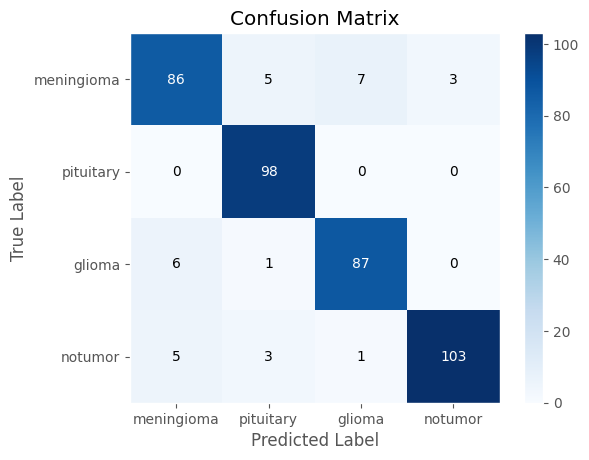

In [57]:
plt_confusion_matrix(test_data.dataset.targets(), np.array(preds), test_data.dataset.classes)

<a name='6'></a>
## <a id='toc7_'></a>Regularization [](#toc0_)

* **Batch Norm**
> **The need for Batch Norm**:<br>
Consider any of the hidden layers of a network. The activations from the previous layer are simply the inputs to this layer. For instance, from the perspective of Layer 2 in the picture below, if we “blank out” all the previous layers, the activations coming from Layer 1 are no different from the original inputs.<br>
The same logic that requires us to normalize the input for the first layer will also apply to each of these hidden layers.

    > **How Does Batch Norm work**?<br>
Batch Norm is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.
Just like the parameters (eg. weights, bias) of any network layer, a Batch Norm layer also has parameters of its own.

* **Dropout**

    The dropout layer functions by randomly deactivating a portion of input units during each training update. This implies that during forward propagation, certain neurons in the network are ‘dropped out’ or temporarily disregard, along with their associated connections, based on a specific probability.

In [31]:
del model

In [32]:
model = CNN(num_channels=3, classes=len(train_data.dataset.size), regularization=True).to(device)

In [36]:
H = train(model, train_data_loder, test_data_loder, loss_func, opt, device)

EPOCH: 1/40
Train loss: 1.098606, Train accuracy: 0.5457
Test loss: 0.731072, Test accuracy: 0.7062
EPOCH: 2/40
Train loss: 0.699673, Train accuracy: 0.7193
Test loss: 0.563422, Test accuracy: 0.7901
EPOCH: 3/40
Train loss: 0.535468, Train accuracy: 0.7901
Test loss: 0.422236, Test accuracy: 0.8370
EPOCH: 4/40
Train loss: 0.445432, Train accuracy: 0.8074
Test loss: 0.358848, Test accuracy: 0.8691
EPOCH: 5/40
Train loss: 0.348198, Train accuracy: 0.8560
Test loss: 0.315469, Test accuracy: 0.8790
EPOCH: 6/40
Train loss: 0.262604, Train accuracy: 0.9029
Test loss: 0.370261, Test accuracy: 0.8593
EPOCH: 7/40
Train loss: 0.194494, Train accuracy: 0.9202
Test loss: 0.285488, Test accuracy: 0.8963
EPOCH: 8/40
Train loss: 0.102321, Train accuracy: 0.9695
Test loss: 0.500206, Test accuracy: 0.8469
EPOCH: 9/40
Train loss: 0.146698, Train accuracy: 0.9449
Test loss: 0.534061, Test accuracy: 0.8790
EPOCH: 10/40
Train loss: 0.154848, Train accuracy: 0.9523
Test loss: 0.347009, Test accuracy: 0.8938

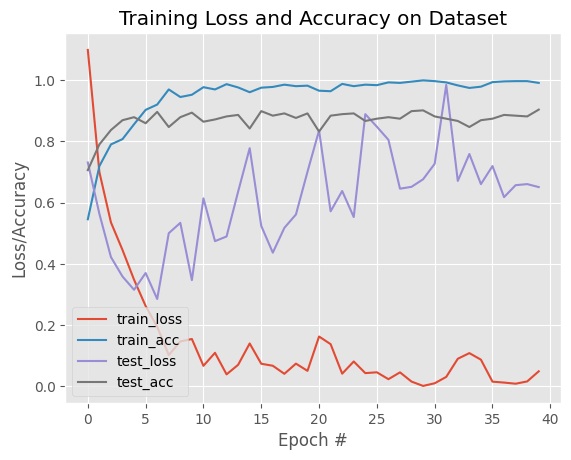

In [42]:
plot_loss_acc(H)

In [43]:
preds = test(model, test_data, test_data_loder, device)

              precision    recall  f1-score   support

  meningioma       0.89      0.77      0.83       101
   pituitary       0.93      0.99      0.96        98
      glioma       0.87      0.91      0.89        94
     notumor       0.92      0.94      0.93       112

    accuracy                           0.90       405
   macro avg       0.90      0.90      0.90       405
weighted avg       0.90      0.90      0.90       405



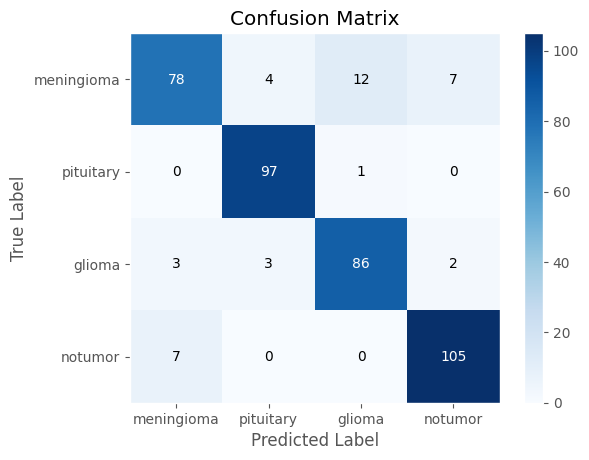

In [44]:
plt_confusion_matrix(test_data.dataset.targets(), np.array(preds), test_data.dataset.classes)

## <a id='toc8_'></a>Results [](#toc0_)
As you can see, the model achieves higher accuracy without regularization. The reason behind this is that we employ oversampling, and some of the data is present in both the training and testing sets. Consequently, when the model overfits during the initial phase, it attains a good accuracy in the test set as well. However, in reality, when we present it with completely unseen data, the model with regularization performs better.

<a name='7'></a>
## <a id='toc9_'></a>References [](#toc0_)
* [PyTorch: Training your first Convolutional Neural Network (CNN)](https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/)
* [Hyper-parameter selection for Convolutional Neural Networks](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7)
* [How to decide the hyperparameters in CNN](https://medium.com/@sengupta.joy4u/how-to-decide-the-hyperparameters-in-cnn-bfa37b608046)
* [Introduction to the Adam Optimization](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)
* [What is Adam Optimizer?](https://www.analyticsvidhya.com/blog/2023/09/what-is-adam-optimizer/)
* [Batch Norm Explained Visually](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739)